In [12]:
import numpy as np
import struct
# import pandas as pd
# import xarray as xr
# import geopandas as gpd
# import regionmask, struct
import matplotlib.pyplot as plt
import rioxarray
from pyproj import Transformer
import cartopy.crs as ccrs

In [13]:
obj = ccrs.LambertAzimuthalEqualArea(105, 47)
obj_proj = obj.to_string()

obj_proj = 'EPSG:3408'

transformer = Transformer.from_crs('EPSG:4326', obj_proj)
transformer_inv = Transformer.from_crs(obj_proj, 'EPSG:4326')

workplace = './'

In [14]:
icesheet = rioxarray.open_rasterio('IceMask01.asc').rio.write_crs(obj_proj)

# icesheet = icesheet.rio.reproject('EPSG:4326')

In [15]:
drang = rioxarray.open_rasterio('PanArcticMask01.asc').rio.write_crs(obj_proj)

In [16]:
topo = rioxarray.open_rasterio('g_mean.asc').rio.write_crs(obj_proj) #.rio.write_nodata(-9999, inplace=True)#.rio.reproject('EPSG:4326')

topo.values[icesheet.values == 1] = -9999 # ocean
topo.values[icesheet.values == 2] = -9999 # ice
topo.values[icesheet.values == -9999] = -9999 # nodata

topo.values[drang.values == 0] = -9999
topo.values[drang.values == 1] = -9999
topo.values[drang.values == -9999] = -9999

# topo = topo.rio.reproject('EPSG:4326')

aaa = 5E6
bbb = 3.75E6

topo = topo.rio.clip_box(
    minx=-aaa,
    miny=-bbb,
    maxx=aaa,
    maxy=bbb,
)

topo_proj = topo.rio.reproject('EPSG:4326')

topo_proj

<xarray.DataArray (band: 1, y: 164, x: 1000)>
array([[[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]]],
      dtype=float32)
Coordinates:
  * x            (x) float64 -179.8 -179.5 -179.1 -178.7 ... 179.1 179.5 179.8
  * y            (y) float64 89.82 89.46 89.1 88.74 ... 32.2 31.84 31.48 31.12
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

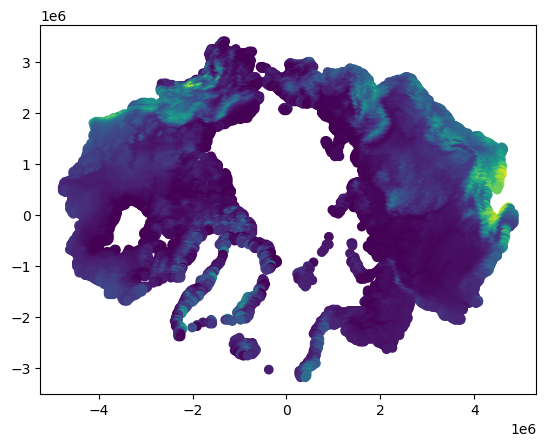

In [17]:
lon, lat = np.meshgrid(topo.x, topo.y)
plt.scatter(lon[topo.values[0,:,:]>0], lat[topo.values[0,:,:]>0], c = topo.values[0,:,:][topo.values[0,:,:]>0])

83.69750371711007 45.52238337503385


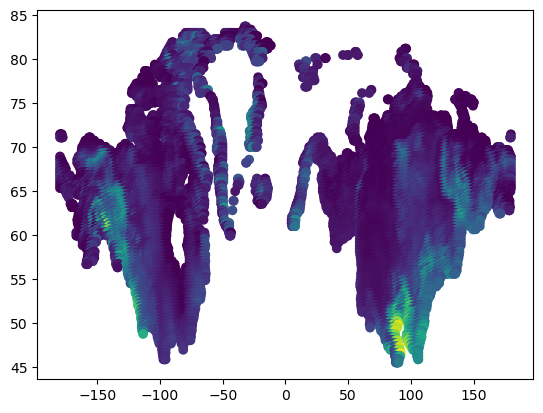

In [18]:
lon2, lat2 = np.meshgrid(topo_proj.x, topo_proj.y)
plt.scatter(lon2[topo_proj.values[0,:,:]>0], lat2[topo_proj.values[0,:,:]>0], c = topo_proj.values[0,:,:][topo_proj.values[0,:,:]>0])

print(lat2[topo_proj.values[0,:,:]>0].max(), lat2[topo_proj.values[0,:,:]>0].min())

In [19]:
topo.rio.to_raster('topo.asc')